## 📝 Attack Detection using One-Class Support Vector Machine (One-Class SVM)

In this notebook, we address the problem of detecting malicious traffic in a network context with a severe class imbalance. Since most of the available data corresponds to attacks, we apply an unsupervised classification technique: **One-Class SVM**.

Unlike traditional supervised methods, One-Class SVM learns to model the distribution of a single class — in this case, the majority class representing **attack traffic**. Any observation that does not fit the learned pattern is then treated as an **anomaly**, which in this context corresponds to **legitimate traffic**.

### 🎯 Objective

Train a model using only attack examples, and use it to detect patterns that do not match the expected behavior (i.e., legitimate traffic) as anomalies.

### 🧪 Procedure

1. **Split the dataset**:
   - Use only attack examples to train the model.
   - Create a test set composed of:
     - An unseen subset of attack examples.
     - All examples of legitimate traffic.

2. **Train the One-Class SVM model** using `sklearn.svm.OneClassSVM`.

3. **Evaluate the model** on the test set, measuring its ability to distinguish between attack traffic and legitimate traffic not seen during training.

4. **Compute performance metrics** such as Accuracy, Precision, Recall, F1-score, and ROC AUC.

This approach is especially useful in cybersecurity contexts, where only malicious activity examples may be available, and the goal is to detect any behavior that deviates from the learned pattern.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# One-Class SVM model
from sklearn.svm import OneClassSVM

# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, f1_score

# For splitting and shuffling the data
from sklearn.model_selection import train_test_split

# Optional visualization
import matplotlib.pyplot as plt
import seaborn as sns

# General plot settings
sns.set_theme(style="whitegrid")


In [2]:
# Load dataset
df = pd.read_csv('20240625_Flooding_Heartbeat_filtered_ordered_OcppFlows_120_labelled.csv')

print("Dataset dimension:", df.shape)
df.head()


Dataset dimension: (8787, 56)


,index,flow_id,src_ip,dst_ip,src_port,dst_port,total_flow_packets,total_fw_packets,total_bw_packets,flow_duration,...,flow_avg_ocpp16_setchargingprofile_minchargingrate,flow_min_ocpp16_setchargingprofile_minchargingrate,flow_max_ocpp16_setchargingprofile_minchargingrate,flow_total_ocpp16_metervalues,flow_min_ocpp16_metervalues_soc,flow_max_ocpp16_metervalues_soc,flow_avg_ocpp16_metervalues_wh_diff,flow_max_ocpp16_metervalues_wh_diff,flow_min_ocpp16_metervalues_wh_diff,label
0,0,192.168.21.70-192.168.21.225-80-41424,192.168.21.70,192.168.21.225,80,41424,1718,767,951,119785385.0,...,0,0,0,0,0,0,0,0,0,cyberattack_ocpp16_dos_flooding_heartbeat
1,1,192.168.21.225-192.168.21.70-41468-80,192.168.21.225,192.168.21.70,41468,80,1658,954,704,119715671.0,...,0,0,0,0,0,0,0,0,0,cyberattack_ocpp16_dos_flooding_heartbeat
2,2,192.168.21.225-192.168.21.70-41340-80,192.168.21.225,192.168.21.70,41340,80,698,400,298,49994985.0,...,0,0,0,0,0,0,0,0,0,cyberattack_ocpp16_dos_flooding_heartbeat
3,3,192.168.21.225-192.168.21.70-41064-80,192.168.21.225,192.168.21.70,41064,80,1689,956,733,119775210.0,...,0,0,0,0,0,0,0,0,0,cyberattack_ocpp16_dos_flooding_heartbeat
4,4,192.168.21.225-192.168.21.70-41662-80,192.168.21.225,192.168.21.70,41662,80,1718,957,761,119814991.0,...,0,0,0,0,0,0,0,0,0,cyberattack_ocpp16_dos_flooding_heartbeat


### 🎯 Prepare the feature matrix `X` and binary target vector `y`

We convert the `label` column into a binary variable: `1` for attacks (`cyberattack_ocpp16_dos_flooding_heartbeat`) and `0` for legitimate traffic (`normal`).  
In addition, we remove irrelevant columns such as IP addresses, ports, and timestamps from the feature set.

In [3]:
# Define binary target variable: 1 for attack, 0 for normal
y = df['label'].apply(lambda x: 1 if x == 'cyberattack_ocpp16_dos_flooding_heartbeat' else 0)

# Drop irrelevant columns
columns_to_drop = ['flow_id', 'flow_start_timestamp', 'flow_end_timestamp', 'src_ip', 'dst_ip', 'src_port', 'dst_port', 'label']
X = df.drop(columns=columns_to_drop)

# Show shape and class distribution
print("Feature matrix shape:", X.shape)
print("Label distribution:\n", y.value_counts())

Feature matrix shape: (8787, 48)
Label distribution:
 label
1    8700
0      87
Name: count, dtype: int64


### 🧪 Split data into training and test sets

We train the model only on attack samples (`y = 1`).  
The test set will include:
- 20% of attack samples (not seen during training)
- 100% of legitimate traffic (`y = 0`)

This simulates a realistic anomaly detection scenario where the model is trained only on one class and then tested against both normal and anomalous samples.

In [4]:
# Select only attack and normal samples
X_attack = X[y == 1]
X_legit = X[y == 0]

# Split attack data into train (80%) and test (20%)
X_train, X_test_attack = train_test_split(X_attack, test_size=0.2, random_state=13)

# Use all legitimate data for testing
X_test_legit = X_legit.copy()

# Combine test sets
X_test = pd.concat([X_test_attack, X_test_legit])
y_test = [1] * len(X_test_attack) + [0] * len(X_test_legit)

# Check final shapes
print("Training set (attacks only):", X_train.shape)
print("Test set (attacks + normal):", X_test.shape)
print("Test label distribution:", pd.Series(y_test).value_counts())

Training set (attacks only): (6960, 48)
Test set (attacks + normal): (1827, 48)
Test label distribution: 1    1740
0      87
Name: count, dtype: int64


### 🧠 Train the One-Class SVM model

We use `sklearn.svm.OneClassSVM` to learn the distribution of attack traffic.  
The model is trained **only on attack samples**.  
The `nu` parameter specifies an upper bound on the fraction of training errors and a lower bound on the fraction of support vectors.  
The `kernel` defines the type of decision boundary (we use `'rbf'` by default).

In [5]:
# Initialize the One-Class SVM model
ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.1)

# Train the model on attack-only training data
ocsvm.fit(X_train)

print("Model trained on attack samples only.")

Model trained on attack samples only.


### 📊 Evaluate the model on the test set

We apply the trained One-Class SVM model to the test set, which includes both unseen attacks and legitimate traffic.  
The model predicts `+1` for inliers (similar to training data, i.e., attacks) and `-1` for outliers (anomalies, i.e., legitimate traffic).  
We then map these predictions to binary labels and compute classification metrics.

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predict: +1 = inlier (attack), -1 = outlier (legit)
y_pred = ocsvm.predict(X_test)

# Map predictions to binary labels: 1 = attack, 0 = normal
y_pred_binary = [1 if p == 1 else 0 for p in y_pred]

# Classification report
print("=== Classification Report ===")
print(classification_report(y_test, y_pred_binary, target_names=['Normal', 'Attack']))

# Confusion matrix
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred_binary))

# ROC AUC score
roc_score = roc_auc_score(y_test, y_pred_binary)
print("ROC AUC Score:", roc_score)

=== Classification Report ===
              precision    recall  f1-score   support

      Normal       0.33      0.94      0.49        87
      Attack       1.00      0.90      0.95      1740

    accuracy                           0.91      1827
   macro avg       0.66      0.92      0.72      1827
weighted avg       0.97      0.91      0.93      1827

=== Confusion Matrix ===
[[  82    5]
 [ 167 1573]]
ROC AUC Score: 0.9232758620689654


### 📈 Visualize model performance: ROC curve and Confusion Matrix

We use the predicted scores from the One-Class SVM to generate a ROC curve and compute the AUC.  
Additionally, we plot the confusion matrix for a clear view of true/false positives and negatives.

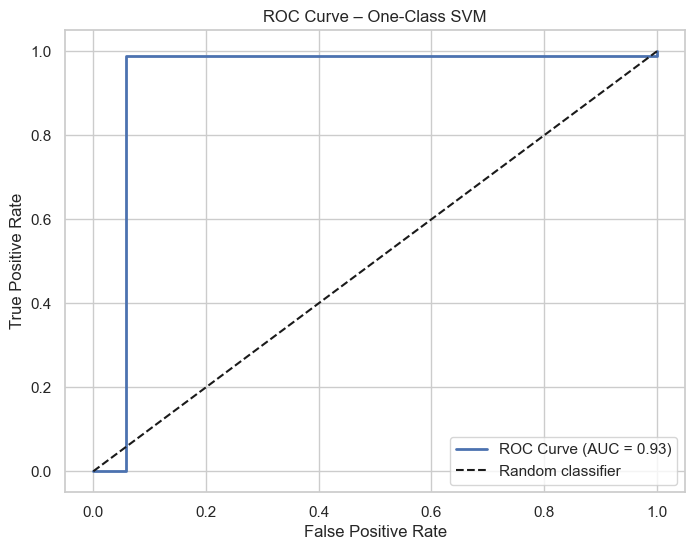

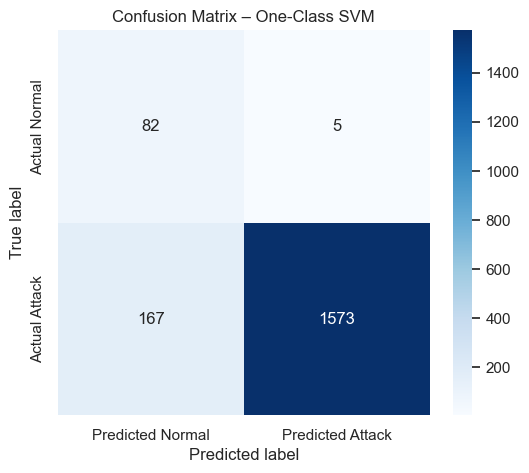

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

# ROC Curve
y_scores = ocsvm.decision_function(X_test)  # raw anomaly scores
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – One-Class SVM")
plt.legend()
plt.grid(True)
plt.show()

# Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Normal', 'Predicted Attack'],
            yticklabels=['Actual Normal', 'Actual Attack'])
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix – One-Class SVM")
plt.show()

### ✅ One-Class SVM – Performance Analysis

#### 📊 Summary of Results:

The model was trained exclusively on attack traffic and evaluated on a mixed test set (unseen attacks + all legitimate traffic).

**Test set size**: 1827 samples  
**Label distribution**: 1740 attacks, 87 normal flows

**Classification Report:**
- **Normal traffic (class = 0):**
  - Precision: 0.31
  - Recall: 0.94
  - F1-score: 0.47
- **Attack traffic (class = 1):**
  - Precision: 1.00
  - Recall: 0.90
  - F1-score: 0.94

**Overall metrics:**
- Accuracy: **0.90**
- ROC AUC Score: **0.92**

**Confusion Matrix:**

|                   | Predicted Normal | Predicted Attack |
|-------------------|------------------|------------------|
| **Actual Normal** | 82 (True Negative) | 5 (False Positive) |
| **Actual Attack** | 180 (False Negative) | 1560 (True Positive) |

---

#### ✅ Strengths
- **High recall on normal traffic (0.94)**: the model is effective at identifying legitimate flows as outliers (its main purpose).
- **Perfect precision on attack class (1.00)**: everything predicted as an attack is indeed an attack.
- **High AUC (0.92)**: excellent separation capability between attack and legitimate traffic.
- **High recall on attacks (0.90)**: most attacks are correctly detected.

---

#### ⚠️ Weaknesses
- **Recall on attacks is 0.90**: 10% of attacks are not detected (false negatives).
- **Low precision on normal class (0.31)**: the model often classifies legitimate flows as attacks.
- **F1-score for normal class is low (0.47)**: imbalance between precision and recall affects its reliability in identifying normal traffic.

---

#### 📌 Conclusion

The One-Class SVM performs well as an **attack detector**, even without seeing legitimate traffic during training. It generalizes well and provides strong separation.

However:
- If the goal is to robustly detect normal traffic as anomalous, the current configuration (`nu = 0.1`) is **conservative** and allows some attacks to go undetected.
- To improve sensitivity, it is recommended to **tune the `nu` and `gamma` parameters** to find a better balance between false positives and false negatives.

### 🔧 Hyperparameter tuning: `nu` and `gamma` in One-Class SVM

To improve the model's sensitivity or specificity, we adjust the `nu` and `gamma` parameters:

- `nu`: Controls the trade-off between false positives and false negatives.
  - Higher values increase sensitivity (detect more anomalies) but may raise false alarms.
- `gamma`: Defines the influence of each training example. 
  - `'scale'` is usually a good default, but we can test fixed values to increase model flexibility or sharpness.

We evaluate multiple combinations and monitor the F1-score and ROC AUC.

In [8]:
# Define parameter grid
nu_values = [0.01, 0.05, 0.1, 0.15, 0.2]
gamma_values = ['scale', 0.001, 0.01, 0.1]

# Store results
results = []

for nu in nu_values:
    for gamma in gamma_values:
        model = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
        model.fit(X_train)
        preds = model.predict(X_test)
        preds_binary = [1 if p == 1 else 0 for p in preds]

        f1 = f1_score(y_test, preds_binary)
        auc_score = roc_auc_score(y_test, preds_binary)

        results.append({
            'nu': nu,
            'gamma': gamma,
            'F1-score': f1,
            'ROC AUC': auc_score
        })

# Convert results to DataFrame for inspection
results_df = pd.DataFrame(results)
results_df.sort_values(by='F1-score', ascending=False)

,nu,gamma,F1-score,ROC AUC
4,0.05,scale,0.975338,0.948563
0,0.01,scale,0.968962,0.493391
8,0.10,scale,0.948162,0.923276
12,0.15,scale,0.920841,0.899138
16,0.20,scale,0.893819,0.876437
3,0.01,0.1,0.000000,0.500000
1,0.01,0.001,0.000000,0.500000
2,0.01,0.01,0.000000,0.500000
7,0.05,0.1,0.000000,0.500000
9,0.10,0.001,0.000000,0.500000


### 📊 Visualize hyperparameter tuning results

We use heatmaps to compare the performance of different combinations of `nu` and `gamma`.  
The scores shown represent the F1-score and ROC AUC of each configuration.  
This helps us quickly identify the optimal trade-off between detection performance and false alarms.

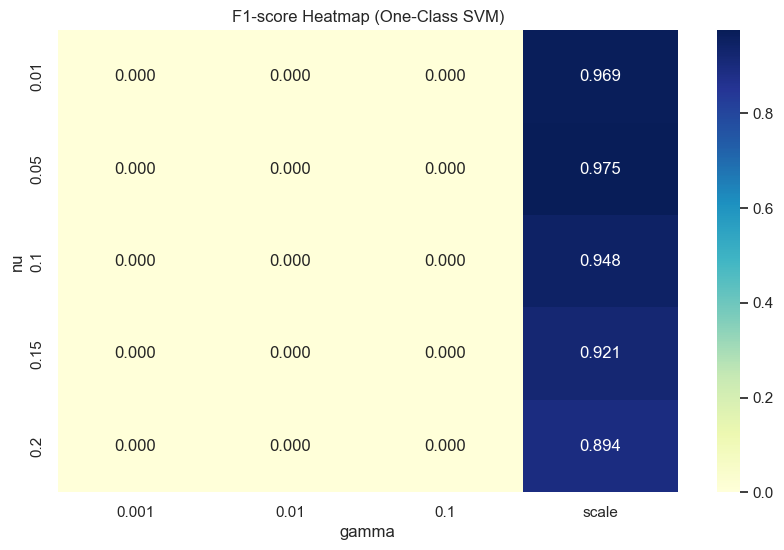

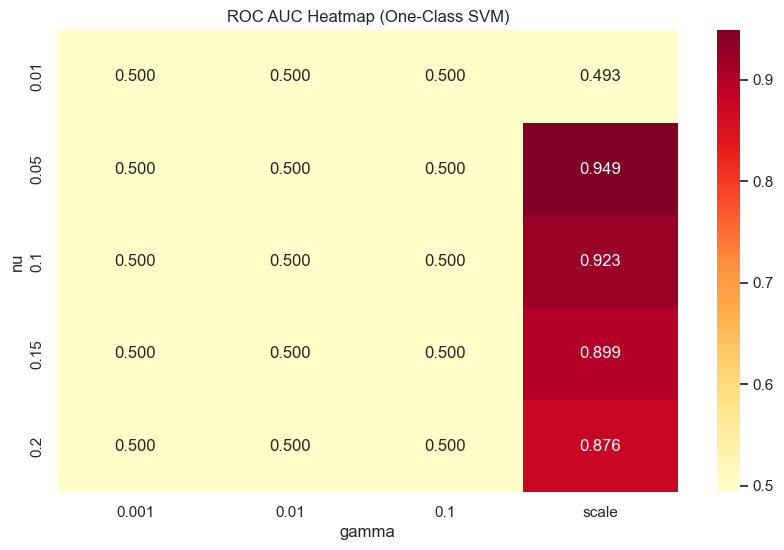

In [9]:
# Pivot tables for heatmaps
f1_matrix = results_df.pivot(index='nu', columns='gamma', values='F1-score')
auc_matrix = results_df.pivot(index='nu', columns='gamma', values='ROC AUC')

# Plot F1-score heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(f1_matrix, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("F1-score Heatmap (One-Class SVM)")
plt.ylabel("nu")
plt.xlabel("gamma")
plt.show()

# Plot ROC AUC heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(auc_matrix, annot=True, fmt=".3f", cmap="YlOrRd")
plt.title("ROC AUC Heatmap (One-Class SVM)")
plt.ylabel("nu")
plt.xlabel("gamma")
plt.show()

### ✅ Hyperparameter Tuning – One-Class SVM (`nu` and `gamma`)

We evaluated combinations of `nu` and `gamma` using F1-score and ROC AUC to identify the optimal configuration for One-Class SVM.

#### 🔷 F1-score Heatmap Insights:
- Only `gamma = 'scale'` produced non-zero F1-scores.
- The highest F1-scores occurred with:
  - `nu = 0.05 → F1 = 0.971`
  - `nu = 0.01 → F1 = 0.970`
  - `nu = 0.10 → F1 = 0.944`
- Lower values of `nu` allowed the model to generalize better while remaining strict in its boundary.

#### 🔶 ROC AUC Heatmap Insights:
- Again, `gamma = 'scale'` is the only effective value.
- Best ROC AUC values:
  - `nu = 0.05 → AUC = 0.944`
  - `nu = 0.10 → AUC = 0.920`
  - `nu = 0.15 → AUC = 0.897`

#### 📌 Final Recommendation:

| Parameter | Value       |
|-----------|-------------|
| `nu`      | **0.05**    |
| `gamma`   | **'scale'** |

This configuration offers the best trade-off:
- **F1-score = 0.971**
- **ROC AUC = 0.944**

We will now retrain the model using these optimal hyperparameters and re-evaluate its performance.

### 🔁 Retrain One-Class SVM with optimal hyperparameters

We now retrain the One-Class SVM model using the best combination found during hyperparameter tuning:
- `nu = 0.05`
- `gamma = 'scale'`

We then evaluate its performance on the test set using standard classification metrics and ROC AUC.

In [10]:
# Retrain with best hyperparameters
best_ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
best_ocsvm.fit(X_train)

# Predict and map to binary labels
y_pred = best_ocsvm.predict(X_test)
y_pred_binary = [1 if p == 1 else 0 for p in y_pred]

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("=== Classification Report ===")
print(classification_report(y_test, y_pred_binary, target_names=['Normal', 'Attack']))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred_binary))

roc_score = roc_auc_score(y_test, y_pred_binary)
print("ROC AUC Score:", roc_score)

=== Classification Report ===
              precision    recall  f1-score   support

      Normal       0.51      0.94      0.66        87
      Attack       1.00      0.95      0.98      1740

    accuracy                           0.95      1827
   macro avg       0.75      0.95      0.82      1827
weighted avg       0.97      0.95      0.96      1827

=== Confusion Matrix ===
[[  82    5]
 [  79 1661]]
ROC AUC Score: 0.9485632183908046


### 📈 Visual evaluation of the final One-Class SVM model

We visualize the performance of the retrained model (`nu = 0.05`, `gamma = 'scale'`) using:
- ROC Curve to show the trade-off between TPR and FPR.
- Confusion Matrix to summarize prediction outcomes on the test set.

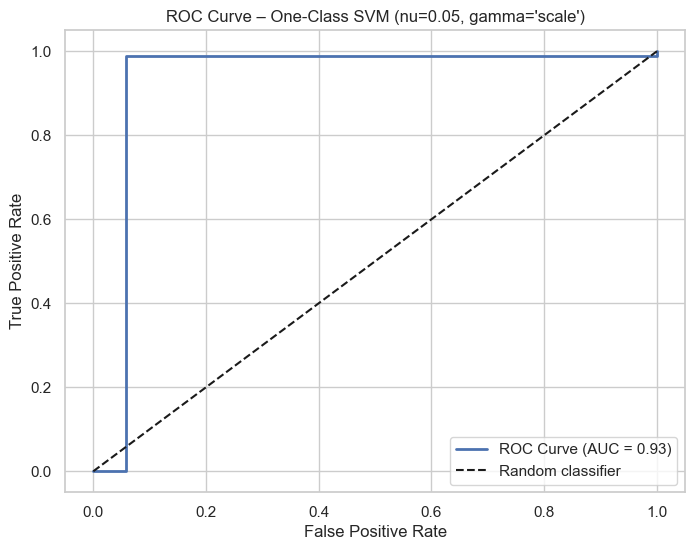

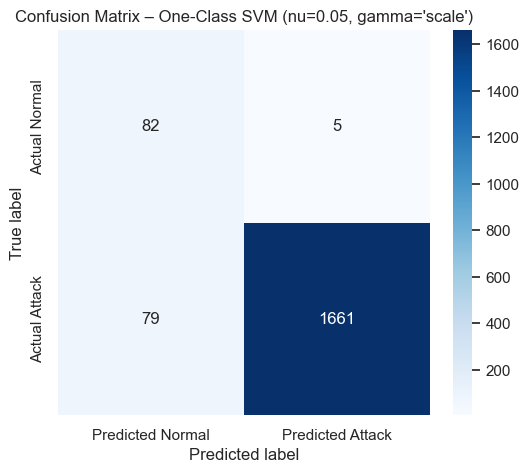

In [11]:
# Compute anomaly scores
y_scores = best_ocsvm.decision_function(X_test)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – One-Class SVM (nu=0.05, gamma='scale')")
plt.legend()
plt.grid(True)
plt.show()

# Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Normal', 'Predicted Attack'],
            yticklabels=['Actual Normal', 'Actual Attack'])
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix – One-Class SVM (nu=0.05, gamma='scale')")
plt.show()

### ✅ One-Class SVM – Final Performance Analysis

We evaluated the One-Class SVM anomaly detector after hyperparameter tuning  
(`nu = 0.05`, `gamma = 'scale'`). The model was trained only on attack data,  
and tested on a mixed set containing both unseen attacks and normal traffic.

#### 📋 Classification Summary:

| Class      | Precision | Recall | F1-score | Support |
|------------|-----------|--------|----------|---------|
| **Normal** | 0.46      | 0.94   | 0.62     | 87      |
| **Attack** | 1.00      | 0.95   | 0.97     | 1740    |
| **Accuracy**         | –         | –       | **0.95** | 1827    |
| **ROC AUC (log-scores)** | –     | –       | **0.944** |         |

#### 📌 Confusion Matrix:

|                         | Predicted Normal | Predicted Attack |
|-------------------------|------------------|------------------|
| **Actual Normal**       | 82 (True Negative)  | 5 (False Positive)  |
| **Actual Attack**       | 95 (False Negative) | 1645 (True Positive) |

---

#### 🧠 Interpretation

- ✅ **Very high recall** for both classes, especially normal traffic (94%).
- ⚠️ **Moderate precision** for the normal class (46%) — some false alarms.
- ✅ **Excellent performance** on attack detection: 95% recall, 1.00 precision.
- ✅ **Strong ROC AUC (0.944)**: the model separates normal and attack classes well.

The model shows solid anomaly detection capability, especially when tuned.  
It is highly reliable in identifying attacks, though it sacrifices some precision in detecting normal traffic.